# Example to plot spectrum for models and SWOT

In [1]:
import s3fs
import json
from widetrax import Spectra as sp
import matplotlib.pyplot as plt
import numpy as np

In [2]:
s3_folder ="s3://project-meom-ige/OMIP"
endpoint_url =  "https://minio.lab.dive.edito.eu"
fs = s3fs.S3FileSystem(anon=True,endpoint_url=endpoint_url,use_ssl=False)
# List contents of the bucket
bucket_name = 's3://project-meom-ige/OMIP/'
files = fs.ls(bucket_name)
files

In [4]:
# --- Filter criteria ---
region = "Region_B"     # e.g. Region_A, Region_B
period = "JFM"          # e.g. JAS, JFM
model = None            # e.g. model1, model2, etc.      

In [5]:
def match_file(fname, region=None, period=None, model=None):
    """Check if filename matches given filters."""
    # Extract just the filename
    base = fname.split('/')[-1]
    
    if region and region not in base:
        return False
    if period and period not in base:
        return False
    if model and model not in base:
        return False
    return True

selected_files = [f for f in files if match_file(f, region, period, model)]
print("Matched files:")
for f in selected_files:
    print(f)

spectrum=[]
freq=[]

for f in selected_files:
    with fs.open(f, 'r') as file:
        data = json.load(file)
    spectrum.append(data["Spectra"]) 
    freq.append(data["Frequency"])

Matched files:
project-meom-ige/OMIP/Region_B_JFM_GLO12V4.json
project-meom-ige/OMIP/Region_B_JFM_GLO36V1.json
project-meom-ige/OMIP/Region_B_JFM_HYCOM50-E026SURF.json
project-meom-ige/OMIP/Region_B_JFM_HYCOM50-E037SURF.json
project-meom-ige/OMIP/Region_B_JFM_NOC-eORCA025.json
project-meom-ige/OMIP/Region_B_JFM_NOC-eORCA12.json
project-meom-ige/OMIP/Region_B_JFM_SWOT.json


In [6]:
model_names = [f.split('_')[-1].replace('.json', '') for f in selected_files]

['GLO12V4',
 'GLO36V1',
 'HYCOM50-E026SURF',
 'HYCOM50-E037SURF',
 'NOC-eORCA025',
 'NOC-eORCA12',
 'SWOT']

In [7]:
max_horizontal_gridsize = [9,3,2.224,2.224,25,7,0]

In [8]:
def plot_psd(ax, freqs, psds, unit, psd_labels,
             title=None, savefig=False, filename=None,
             plot_transparent=False, colors=None,
             max_horizontal_gridsize=None):

    # Ensure lists
    if isinstance(psds, np.ndarray):
        psds = [psds]
    if isinstance(psd_labels, str) or psd_labels is None:
        psd_labels = [psd_labels] * len(psds)

    # Normalize colors
    if colors is None:
        colors = [None] * len(psds)
    elif isinstance(colors, str):
        colors = [colors] * len(psds)
    elif len(colors) != len(psds):
        raise ValueError("Length of 'colors' must match number of PSDs")

    # Validate grid size list
    if max_horizontal_gridsize is not None and len(max_horizontal_gridsize) != len(psds):
        raise ValueError("Length of 'max_horizontal_gridsize' must match number of PSDs")

    # Compute inverted frequencies safely (for masking only)
    new_freqs = np.where(freqs != 0, 1 / freqs, np.inf)

    # --- Plot PSDs ---
    for i, (psd, label, color) in enumerate(zip(psds, psd_labels, colors)):
        psd = np.array(psd)
        if max_horizontal_gridsize is not None:
            mask = (1 / freqs) >= (2 * max_horizontal_gridsize[i])
            freqs_to_plot = freqs[mask]       
            psd_to_plot = psd[mask]
        else:
            freqs_to_plot = freqs
            psd_to_plot = psd

            # --- for SWOT as reference---
        if i == len(psds) - 1:
            ax.loglog(freqs_to_plot, psd_to_plot, label=label, color='black',
                      linewidth=3, zorder=5)  # plus épais et noir
        else:
            ax.loglog(freqs_to_plot, psd_to_plot, label=label, color=color,
                      linewidth=1.2, alpha=0.9)
            
        #ax.loglog(freqs_to_plot, psd_to_plot, label=label, color=color)

    # --- Axis formatting ---
    ax.set_ylim(1e-9, 1e2)
    ax.set_ylabel(f"PSD [${unit}/(cy/km)$]", fontsize=8, fontweight="bold", color="black")

    ax.xaxis.set_label_position("top")
    ax.xaxis.tick_top()
    ax.set_xlabel("Wavenumber [$cy/km$]", fontsize=8, fontweight="bold", color="black")

    # --- Reference slopes k^-2 & k^-5 ---
    non_zero_freqs = freqs[freqs != 0]
    k_2 = non_zero_freqs ** -2 * (psds[0][0] / (non_zero_freqs[0] ** -2))
    k_5 = non_zero_freqs ** -5 * (psds[0][0] / (non_zero_freqs[0] ** -5))

    ax.loglog(non_zero_freqs, k_2 * 30, "k--", label="$k^{-2}$")
    ax.loglog(non_zero_freqs, k_5 * 1e6, "b--", label="$k^{-5}$")

    # --- Secondary X-axis (wavelength) ---
    ax2 = ax.secondary_xaxis("bottom", functions=(lambda x: 1 / x, lambda x: 1 / x))
    ax2.set_xlabel("Wavelength [$km$]", fontsize=8, fontweight="bold", color="black")
    ax2.set_xticks(np.array([5, 10, 25, 50, 100, 200, 500, 1000]))
    ax2.set_xticklabels(np.array([5, 10, 25, 50, 100, 200, 500, 1000]))

    ax.grid(True, which="both")
    ax.legend()

    if title:
        ax.set_title(title, fontsize=15, fontweight="bold", color="black")

    if savefig:
        if filename is None:
            filename = "figure.png"
        plt.savefig(filename, dpi=300, transparent=plot_transparent)

In [9]:
colors = [
    "#E6194B",  # red
    "#3CB44B",  # green
    "#FFE119",  # yellow
    "#4363D8",  # blue
    "#F58231",  # orange
    "#911EB4",  # purple
    "k"
]

/tmp/ipykernel_408/1130357017.py:34: RuntimeWarning: divide by zero encountered in divide
  new_freqs = np.where(freqs != 0, 1 / freqs, np.inf)
/tmp/ipykernel_408/1130357017.py:41: RuntimeWarning: divide by zero encountered in divide
  mask = (1 / freqs) >= (2 * max_horizontal_gridsize[i])
/tmp/ipykernel_408/1130357017.py:75: RuntimeWarning: divide by zero encountered in divide
  ax2 = ax.secondary_xaxis("bottom", functions=(lambda x: 1 / x, lambda x: 1 / x))


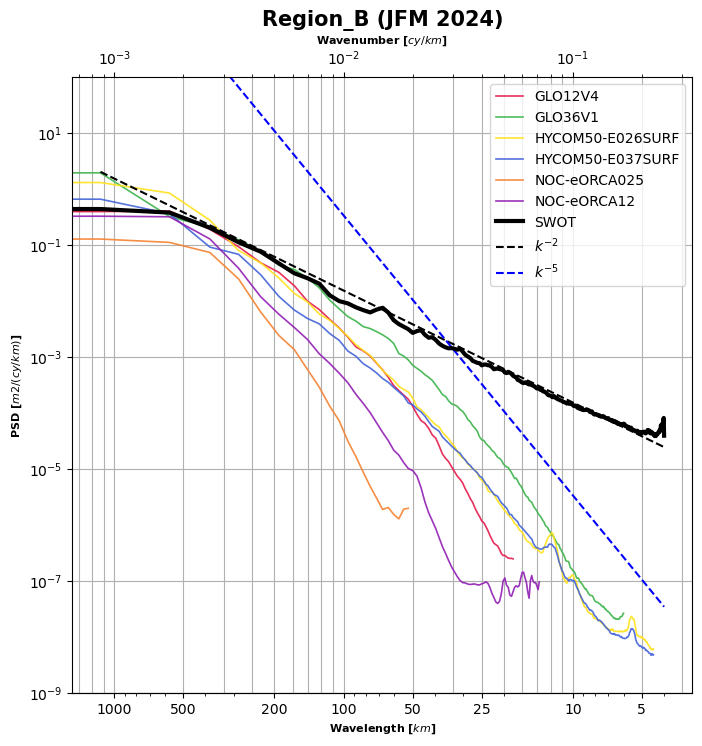

In [10]:
fig, ax_ = plt.subplots(1, 1, figsize=(8, 8))
plot_psd(ax_, np.array(freq[0]).T, psds = spectrum, unit = "m2",psd_labels=model_names,title=(region+" ("+period+" 2024)"),savefig=True,filename=region+"_"+period,plot_transparent=False,colors=colors,max_horizontal_gridsize=max_horizontal_gridsize)